# RNN

本 notebook 将在[手写数字识别作业](https://github.com/BeiYazi0/DL_homework/tree/main/SP)的基础上进行修改，为 简单[框架](https://github.com/BeiYazi0/cnn)增加循环层，并对其进行小小的改动。

直接运行 train.py 可训练一个模型。
直接运行 test.py 可加载一个模型。

---

## 1.要求

### 1.1模型

反向传播 50 个时刻，从第 101 个时刻开始更新权重。

### 1.2要求

![png](./img/work.png)

---

## 2.准备工作

### 2.1导入依赖。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import convolve2d

### 2.2 POI数据集

#### 2.2.1 加载POI数据集

可以看到 POI 数据集中 SquPOI 是一个矩阵，其第一个维度大小是 3，包含三维坐标信息。

In [2]:
data = loadmat('data/POI.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Jun 11 08:32:17 2020',
 '__version__': '1.0',
 '__globals__': [],
 'SquPOI': array([[ 1.58580127,  1.66956005,  1.73391882, ...,  2.08913278,
          2.45552439,  2.81379444],
        [ 2.30682267,  2.1626592 ,  2.08736971, ...,  1.87522737,
          1.44400496,  1.2024588 ],
        [52.28089488, 50.91113804, 50.89630474, ..., 50.3960555 ,
         49.3056074 , 49.58236687]])}

数据集的大小为 2427x3。

In [3]:
data = data['SquPOI'].T
data.shape

(2427, 3)

#### 2.2.2 数据格式标准化

零均值化，记录均值。

In [4]:
data_mean = data.mean(axis = 0)
data -= data_mean

训练数据和测试数据

In [6]:
X_train = data[:600]
y_train = data[1:601]
X_test = data[600:-1]
y_test = data[601:]

### 2.3 激活函数
#### 2.3.1 ReLU & Sigmoid & Softma

In [5]:
def ReLU(z):
    '''
    ReLU 函数
    Args:
        z (m, n): 输入
    Returns:
        g (m, n): ReLU 函数输出
    '''
    return np.maximum(0, z)

def sigmoid(z):
    '''
    sigmoid 函数
    Args:
        z (m, n): 输入
    Returns:
        g (m, n): sigmoid 函数输出
    '''
    d = 1 + np.exp(-z)
    return 1. / d

def softmax(z):
    '''
    softmax 函数
    Args:
        z (m, n): 输入
    Returns:
        g (m, n): softmax 函数输出
    '''
    d = np.exp(z)
    # 注意 d sum时的axis
    return d / d.sum(axis = 1).reshape(-1, 1)

def tanh(z):
    '''
    tanh 函数
    Args:
        z (m, n): 输入
    Returns:
        g (m, n): tanh 函数输出
    '''
    b = np.exp(z)
    c = np.exp(-z)
    return (b - c) / (b + c)

def Linear(z):
    '''
    Linear 函数
    Args:
        z (m, n): 输入
    Returns:
        g (m, n): Linear 函数输出
    '''
    return z

#### 2.3.2 激活函数的梯度的函数

In [6]:
def ReLU_gradient(h):
    return h > 0

def sigmoid_gradient(h):
    return np.multiply(h, (1 - h))

def softmax_gradient(h):
    return np.multiply(h, (1 - h))

def tanh_gradient(h):
    return 1 - np.power(h, 2)

def Linear_gradient(z):
    return 1

---

## 3.RNN构成

### 3.1 循环层

循环层的实现原理如图所示，循环层的输出由当前时刻的输入和上一时刻的输出决定。

![png](./img/recurrent.png)

In [7]:
def recurrent(x, U, W, S_pre, activate_fcn):
    '''
    循环层输出
    Args:
        x (n, ): 输入
        U (t, n): 参数矩阵
        W (t, t): 参数矩阵
        S_pre (t, ): 上一时刻的状态
        activate_fcn method: 激活函数
    Returns:
        S_cur (t, ): 当前时刻的状态
    '''
    return activate_fcn(x @ U.T + S_pre @ W.T)

### 3.2 输出层

In [8]:
def ouput_get(x, V, activate_fcn):
    '''
    输出层输出
    Args:
        x (n, ): 输入
        V (t, n): 参数矩阵
        activate_fcn method: 激活函数
    Returns:
        out (t, ): 当前时刻的状态
    '''
    return activate_fcn(x @ V.T)

---

## 4.构建神经网络

### 4.1 前向传播

由于循环层的输出不仅与当前时刻的输入有关，还与循环层的状态有关，因此前向传播时每次仅处理一个样本，如图所示。

![png](./img/forward.png)

### 4.2 反向传播

RNN 的反向传播算法 BPTT 的原理图如下。

![png](./img/bptt.png)

#### 4.2.1 输出层的反向传播

这里与全连接网络的输出层的反向传播没有太大区别

In [6]:
def output_backward(h, a, error, theta, activate_fcn_gradient):
    '''
    输出层系数更新和反向传播
    Args:
        h (m, t): 正向传播中输出层的激活项输出
        a (m, n): 正向传播中输出层的输入
        error (m, t): error[i, :] 表示输出层在第 i 个时刻的误差
        theta (t, n): 参数矩阵
        activate_fcn_gradient method: 激活函数的梯度函数
    Returns:
        grad (t, n): 输出层系数的梯度
        error_bp (m, n): 输出层向上一层反向传播的误差
    '''
    # 计算delta
    delta = np.multiply(error, activate_fcn_gradient(h))
    
    # 计算 grad
    grad = delta.T @ a 
    
    # 反向传播
    error_bp = delta @ theta
    
    return grad, error_bp

#### 4.2.2 循环层的反向传播

当前时刻的循环层，其误差来自于当前时刻的输出层，以及下一时刻的循环层。

In [7]:
def recurrent_backward(h, a, S_lst, error, U, W, activate_fcn_gradient):
    '''
    循环层系数更新和反向传播
    Args:
        h (m, t): 正向传播中循环层的激活项输出
        a (m, n): 正向传播中循环层的输入
        S_lst (m, t): 循环层的历史状态值
        error (m, t): error[i, :] 表示循环层在第 i 个时刻来自于下一层的误差
        U (t, n): 参数矩阵
        W (t, t): 参数矩阵
        activate_fcn_gradient method: 激活函数的梯度函数
    Returns:
        grad_U (t, n): 循环层系数 U 的梯度
        grad_W (t, t): 循环层系数 W 的梯度
        error_bp (m, n): 循环层向上一层反向传播的误差
    '''
    m, t = error.shape
    
    # 循环层每一个时刻的delta
    delta = np.zeros((m, t))
    v_gradient = activate_fcn_gradient(h)
    # 最后时刻的循环层误差仅来自于当前时刻的输出层
    error_bp_recurrent = np.zeros((1, t))
    for i in range(m - 1, -1, -1):
        # 当前时刻的循环层，其误差来自于当前时刻的输出层，以及下一时刻的循环层。
        t_error = error[i] + error_bp_recurrent
        delta[i] = np.multiply(t_error, v_gradient[i])
        error_bp_recurrent = delta[i] @ W # 传递给上一时刻循环层的误差
    
    # 计算 grad
    grad_U = delta.T @ a 
    grad_W = delta.T @ S_lst
    
    # 反向传播
    error_bp = delta @ U
    
    return grad_U, grad_W, error_bp

### 4.3 损失函数

由于输出是一个三维坐标，所以使用均方误差。

In [8]:
def MSE(h, y):
    '''
    Mean squared error
    Args:
        h (m, k): 输出
        y (m, k): 真实值, k个类别
    Returns:
        cost float: 代价
    '''
    m = y.shape[0]
    
    # compute the cost
    J = np.power(h - y, 2)
    cost = np.sum(J)/2/m

    return cost

### 4.4 层类

构建循环神经网络的构件类。

包括 Input, Recurrent, Output。

Recurrent 类，其部分成员变量和成员方法如下：

1. 成员变量：
    - U_shape: 参数矩阵的大小
    - W_shape: 参数矩阵的大小
    - U: 参数矩阵
    - W: 参数矩阵
    - activate_fcn: 激活函数
    - activate_gradient_fcn: 激活函数的梯度函数
    - input_shape: 该层输入的维度
    - output_shape: 该层输出的维度
    - init_state: 初始状态
2. 成员方法：
    - set_input(x): 设置输入
    - fordwrd_propagate(): 前向传播
    - backward_propagate(error, lr): 反向传播
    - summary(): 返回层类型、输入数据维度、参数量
    - save(): 返回用于构建循环层的参数及参数矩阵

In [9]:
class Recurrent():
    __name__ = "Recurrent"
    '''
    循环层
    '''
    def __init__(self, units, input_shape, activate_fcn, theta = None):
        '''
        Args:
            units int: 输出的维度大小
            input_shape int: 输入该网络层的数据维度
            activate_fcn string: 激活函数
            theta (?): 指定的参数
        '''
        _dict = NetworkDict(0)
        if type(input_shape) != int:
            input_shape = input_shape[0]
        self.input_shape = (input_shape, )
        self.U_shape = (units, input_shape)
        self.W_shape = (units, units)
        # 初始化
        if theta is None or theta.shape != (units, input_shape + units + 1):
            self.U = Kaiming_uniform(input_shape, units)
            self.W = Kaiming_uniform(units, units)
            # 初始状态
            self.init_state = np.zeros((1, units))
        else:
            self.U = theta[:, :input_shape]
            self.W = theta[:, input_shape:-1]
            self.init_state = theta[:, -1]
        
        self.activate_fcn = _dict.get_activate_fcn(activate_fcn)
        self.activate_gradient_fcn = _dict.get_activate_gradient_fcn(activate_fcn)
        self.output_shape = (None, units)
        
        self._str = np.array([self.__name__, activate_fcn])
        
        # 输入，激活项
        self.x = None
        self.a = None

前向传播
这里设定了当发生前向传播时才会修改 init_state，这样方便我们在反向传播时可以知道本次训练的初始状态。

In [10]:
def forward_propagate(self):
    batch_size = self.x.shape[0]
    units = self.output_shape[1]
    output = np.zeros((batch_size, units))

    # 修改本次前向传播的初始状态
    if self.a is not None:
        self.init_state = self.a[-1]

    cur_state = self.init_state # 初始状态
    for i in range(batch_size):
        cur_state = self.recurrent_forward(self.x[i], self.U, self.W, 
                                           cur_state, self.activate_fcn)
        output[i] = cur_state

    self.a = output
    return self.a

反向传播

In [12]:
def backward_propagate(self, error, lr):
    S_lst = np.concatenate((self.init_state, self.a[:-1]), axis = 0)
    grad_U, grad_W, error_bp = self.recurrent_backward(self.a, self.x, error, S_lst, 
                                                    self.U, self.W, self.activate_gradient_fcn)
    self.U -= lr * grad_U
    self.W -= lr * grad_W
    return error_bp

返回层的相关参数

In [11]:
def summary(self):
    '''
    返回层类型、输入数据维度、参数量
    Args:
        None
    Returns:
        __name__ string: 层类型
        output_shape tuple(int): 输出数据维度
        params int: 参数量
    '''
    return self.__name__, self.output_shape, np.prod(self.U_shape, dtype=np.int32) + np.prod(self.W_shape, dtype=np.int32)

保存循环层

同时保存其状态。

In [ ]:
def save(self):
        '''
        返回用于构建循环层的参数及参数矩阵的参数
        Args:
            None
        Returns:
            init_params (1, ): 构建隐层的参数
            params (input_shape, units): 隐层参数
            _str (2, ): 构建卷积层的参数
        '''
        init_params = np.array([self.U_shape[0]])
        if self.a is not None:
            self.init_state = self.a[-1]
        return init_params, np.concatenate((self.U, self.W, self.init_state.reshape(-1, 1)), axis = 1), self._str

为了便于获取激活函数及其梯度函数，使用 [NetworkDict](cnn/utils/nndict.py) 类来导入相关函数，使用时只需正确输入相应的字符串即可。

另外，卷积核的初始化采用了 Kaiming 正态分布的[初始化](cnn/utils/weight_initialization.py)，而隐层参数的初始化采用了 Kaiming 均匀分布的初始化。

详见[Pytorch权重初始化方法——Kaiming、Xavier](https://blog.csdn.net/qhaaha/article/details/116141633)。

### 4.5 model

已经准备好 CNN 的构件，下面实现神经网络，其功能包括添加网络层、配置、训练、预测、评估等。

见 [model](cnn/models/model.py)

构造方法

规定了网络的输入层、当前输出的形状和神经网络的名字。

loss_fcn 由 cnn.losses 中导入。

In [ ]:
class Model():
    '''
    神经网络
    '''
    def __init__(self, Input_layer, name = "cnn"):
        '''
        Args:
            Input_layer <class 'Input'>: 输入层
            name string: Model名
        Returns:
            None
        '''
        self.input = Input_layer
        self.cur_output_shape = Input_layer.input_shape
        self.name = name
        
        self.layers = [] # 网络层
        self.lr = 0.0    # 学习率
        
        self.loss_fcn = None # 损失函数

添加网络层

首先判断新加入的层的输入数据维度与模型当前输出数据的维度是否匹配。

接着将网络层加入 Model 的 layers 列表中，并修改模型当前输出数据的维度。

In [3]:
    def add_layer(self, layer):
            '''
            添加层
            Args:
                layer <class '?'>: 网络层
            Returns:
                None
            '''
            assert layer.input_shape == self.cur_output_shape
            self.layers.append(layer)
            self.cur_output_shape = layer.output_shape[1:]

compile

model.compile()的作用就是为搭建好的神经网络模型设置损失函数loss、优化器optimizer、准确性评价函数metrics。

例如
    - model.compile(optimizer = Adam(learning_rate=learning_rate),
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['sparse_categorical_accuracy'])

由于能力有限，在 Model 中，compile 用于指定学习率和设置损失函数和评估函数。

In [4]:
    def compile(self, learning_rate, loss_fcn = "cross_tropy", accuracy_fcn = "categorical_accuracy"):
        '''
        设置损失函数 loss、学习率 learning_rate 和评估函数
        Args:
            learning_rate float: 学习率
            loss_fcn string: 损失函数
            accuracy_fcn string: 评估函数 
        Returns:
            None
        '''
        assert learning_rate > 1e-6 and learning_rate < 1
        self.lr = learning_rate
        self.loss_fcn_name = loss_fcn
        self.accuracy_fcn_name = accuracy_fcn
        
        loss_dic = {"cross_tropy": cross_tropy}
        self.loss_fcn = loss_dic[loss_fcn] if loss_fcn in loss_dic else MSE
        
        accuracy_dic = {"categorical_accuracy": categorical_accuracy, "MAE": MAE}
        self.accuracy_fcn = accuracy_dic[accuracy_fcn] if accuracy_fcn in accuracy_dic else MAE
        
        output_layer = self.layers[-1]
        output_layer.set_flag(loss_fcn == "cross_tropy")

前向传播和后向传播

由于我们已经在各个网络层对应的类中定义了前向传播和后向传播，因此只需要依次调用各层的前后向传播即可实现 Model 的前后向传播，so easy。

In [7]:
def forward(self):
        '''
        前向传播
        Args:
            None
        Returns:
            a (m, k): 输出
        '''
        a = self.input.forward_propagate()
        for layer in self.layers:
            layer.set_input(a)
            a = layer.forward_propagate()
        return a

    def backward(self, error):
        '''
        反向传播
        Args:
            error (N, k): 误差
        Returns:
            None
        '''
        for layer in self.layers[::-1]:
            error = layer.backward_propagate(error, self.lr)

训练

Model.fit() 将训练数据在模型中训练一定次数，返回loss和测量指标，其典型的参数如下。

|参数|含义|
|---|---|
|x	|输入|
|y	|输出|
|batch_size|每一个batch的大小（批尺寸），即训练一次网络所用的样本数|
|epochs|迭代次数，即全部样本数据将被“轮”多少次，轮完训练停止|
|verbose|0:不输出信息；1:显示进度条(一般默认为1)；2:每个epoch输出一行记录|
|validation_split|(0,1)的浮点数，分割数据当验证数据，其它当训练数据|
|validation_data|指定验证数据，该数据将覆盖validation_spilt设定的数据|
|validation_freq|指定验证数据的epoch|
|callback|在每个training/epoch/batch结束时，可以通过回调函数Callbacks查看一些内部信息|

本 Model 的参数暂未采用验证集相关参数和 callback。

值得注意的是，通过 callback 可以在训练中适当修改学习率（如每经过 30 epoch 学习率减半）。

batch_size 默认为 -1，此时为批量，另外需要注意样本数不能恰好分成 batch_size 份的情况。

shuffle 默认为 True，执行将训练模型的数据集进行打乱的操作，详见[TF模型训练中数据shuffle对模型性能的影响](https://blog.csdn.net/pearl8899/article/details/121792312)。

In [ ]:
    def fit(self, x, y, batch_size = -1, epochs = 1, verbose = 1, shuffle = True):
        '''
        训练模型
        Args:
            x (N, C, H, W): 输入
            y (N, k): 输出
            batch_size int: 每次梯度更新的样本数
            epochs int: 训练模型迭代次数
            verbose int: 日志展示
                0:不在标准输出流输出日志信息
                1:显示进度条
                2:每个epoch输出一行记录
            shuffle boolean: 是否在每轮迭代之前混洗数据
        Returns:
            history dict{string: (epochs, )}: 准确率和损失历史值
        '''
        N = x.shape[0]                         # 样本数量
        batchs = int(np.ceil(N / batch_size))  # 总 batch 数
        index = np.arange(N)                   # 用于随机打乱的索引

        # 默认为批量
        if batch_size == -1:
            batch_size = N

        history = {"type": self.accuracy_fcn_name, "accuracy": np.zeros((epochs)), "loss": np.zeros((epochs))}
        print("Model train start.")
        print("=================================================================")
        for i in range(epochs):
            self.state_zero() # 循环层状态初始化
            if shuffle: # 每轮 epoch 打乱数据
                np.random.shuffle(index)
                x = x[index]
                y = y[index]
            h = np.zeros(y.shape) # 每轮的输出
            for j in range(0, N, batch_size):
                k = min(j+batch_size, N)
                Xs = x[j:k] # 每次取 batch_size 个数据
                ys = y[j:k]
                self.input.set_input(Xs)

                # 前向传播
                a = self.forward()
                h[j:k] = a

                if verbose == 1: # batch 日志
                    accuracy, _ = self.accuracy_fcn(y[j:k], a)
                    print("batch %8s/%-8s\t%s\tloss: %-10s" % (j//batch_size+1, batchs, accuracy, np.round(self.loss_fcn(a, ys), 6)))

                # 后向传播
                self.backward(a - ys)

            history["loss"][i] = self.loss_fcn(h, y)
            accuracy, history["accuracy"][i] = self.accuracy_fcn(y, h)
            if verbose > 0: # epoch 日志
                print("_________________________________________________________________")
                print("epoch %8s/%-8s\t%s\tloss: %-10s" % (i+1, epochs, accuracy, np.round(history["loss"][i], 6)))
                print("=================================================================")
        return history

预测和评估

训练好的模型可以对新的数据做出预测和评估。

In [ ]:
    def predict(self, test_data):
        '''
        预测输出
        Args:
            test_data (m, n): 输入
        Return:
            a (m, k): 输出
        '''
        self.input.set_input(test_data)
        return self.forward()
    
    def predict_classes(self, test_data):
        '''
        预测分类，分类问题时使用
        Args:
            test_data (m, n): 输入
        Return:
            classes (m, 1): 输出
        '''
        return self.predict(test_data).argmax(axis = 1)
    
    def evaluate(self, x_test, y_test):
        '''
        模型在测试数据上的准确率和损失
        Args:
            x_test (m, n): 输入
            y_test (m, k): label
        Return:
            accuracy float: 准确率
            loss float: 损失
        '''
        a = self.predict(x_test)
        return self.accuracy_fcn(y_test, a)[0], self.loss_fcn(a, y_test)

查看 Model 的构成

可以查看模型的网络层构成、各层的输出及其参数量。

In [ ]:
    def summary(self):
        '''
        查看模型各个层的组成
        Args:
            None
        Returns:
            None
        '''
        total_params = 0
        print("model name: " + self.name)
        print("_________________________________________________________________")
        print("Layer                        Output Shape              Param #   ")
        print("=================================================================")
        for layer in self.layers:
            name, input_shape, params = layer.summary()
            total_params += params
            print("%-29s%-26s%-28s" % (name, input_shape, params))
            print("_________________________________________________________________")
        print("=================================================================")
        print("Total params: %d" % total_params)
        print("_________________________________________________________________")

### 4.6 模型保存和加载

经过上面的讨论，我们已经具备了搭建一个简单的神经网络的能力，在进行训练前，我们需要思考的是，对于一个训练好的模型，我们应当如何将其保存，以便后面需要再次使用或者继续训练时可以重新加载模型。

一般来说，深度学习的训练数据和训练后的参数都会保存为h5格式文件，这里我们只保存参数。

h5 文件的读写详见[python操作h5(h5py)文件](https://zhuanlan.zhihu.com/p/549538285)。

#### 4.6.1 模型保存

见[modelSave](cnn/models/modelSave.py)。

1. 对于模型来说，需要保存以下变量：
    - input_shape
    - lr
    - layer_cnt: 网络层的数量
    - name
    - loss_fcn_name: 损失函数
2. 对于网络层来说，需要保存以下变量：
    - init_params: 用于构建层的参数 (卷积层：[filters, kernel_size, stride])
    - params: 层的参数 (卷积层: kernel)
    - _str: 相关的字符串列表 （卷积层：["Conv2D", padding(如"valid"), activate_fcn（如"ReLU"）]

值得注意的是，不是所有的层都会有 params 或 init_params (如 flatten 层)。

In [ ]:
def save_model(filename, model):
    '''
    模型保存
    Args:
        filename string: 文件名
        model <class 'Model'>: 模型
    Returns:
        None
    '''
    # 创建文件
    f = h5py.File(filename, "w")
    
    # 存储模型的成员变量
    f.create_dataset("input_shape", data = model.input.input_shape)
    f.create_dataset("lr", data = model.lr)
    f.create_dataset("layer_cnt", data = len(model.layers))
    # 字符串的存储
    dt = h5py.special_dtype(vlen = str)
    data = np.array([model.name, model.loss_fcn_name, model.accuracy_fcn_name])
    ds = f.create_dataset('name', data.shape, dtype = dt)
    ds[:] = data

    # 存储网络层
    for i, layer in enumerate(model.layers):
        save_layer(f, f"layer_{i}", layer)
    
    f.close()

In [ ]:
def save_layer(f, group_name, layer):
    '''
    网络层保存
    Args:
        f <class 'h5py._hl.files.File'>: h5文件
        group_name string: 组名
        layer <class '?'>: 网络层
    Returns:
        None
    '''
    # 创建组
    cur_group = f.create_group(group_name)
    
    # 获取参数
    init_params, params, _str = layer.save()
    
    # 存储 string
    dt = h5py.special_dtype(vlen = str)
    ds = cur_group.create_dataset('_str', _str.shape, dtype = dt)
    ds[:] = _str
    
    # 存储构建参数
    if init_params is None:
        cur_group.create_dataset('init_params_flag', data = 0)
    else:
        cur_group.create_dataset('init_params_flag', data = 1)
        cur_group.create_dataset('init_params', data = init_params)
        
    # 存储参数
    if params is None:
        cur_group.create_dataset('params_flag', data = 0)
    else:
        cur_group.create_dataset('params_flag', data = 1)
        cur_group.create_dataset('params', data = params)



#### 4.6.2 模型加载

见[modelLoad](cnn/models/modelLoad.py)。

根据 model 的参数对其重构是较为简单的，难点在于恢复其网络层及可能的参数。

对卷积层、隐层和输出层的构造方法稍作修改，加入可以指定参数（如卷积核）的情况，若不指定则作初始化。

值得注意的是，初始化网络层的 input_shape 来自于 model 的 cur_output_shape。

In [ ]:
def load_model(filename):
    '''
    模型加载
    Args:
        filename string: 文件名
    Returns:
        model <class 'Model'>: 模型
    '''
    # 读取文件
    f = h5py.File(filename, "r")
    
    # 构建 Model
    input_layer = Input(tuple(f["/input_shape"][:].tolist()))
    name = f["/name"][:].astype('<U32')
    model = Model(input_layer, name[0])
    
    # 添加网络层
    layer_cnt = f["/layer_cnt"][()]
    for i in range(layer_cnt):
        model.add_layer(load_layer(f, f"/layer_{i}", model.cur_output_shape))
    
    # compile
    lr = f["lr"][()]
    model.compile(lr, name[1], name[2])
    
    f.close()
    return model

In [ ]:
def load_layer(f, group_name, input_shape):
    '''
    网络层加载
    Args:
        f <class 'h5py._hl.files.File'>: h5文件
        group_name string: 组名
        input_shape <?>: 输入数据维度
    Returns:
        layer <class '?'>: 网络层
    '''
    # 指定组
    cur_group = f[group_name]
    
    # 获取参数
    if cur_group["init_params_flag"][()] == 1:
        init_params = cur_group["init_params"][:].tolist()
    else:
        init_params = []
    init_params.append(input_shape)
        
    _str = cur_group["_str"][:].astype('<U32').tolist()
    layer_class = layer_dic[_str[0]]
    layer_params = init_params + _str[1:]
    if cur_group["params_flag"][()] == 1:
        layer_params.append(cur_group["params"][:])
    
    return layer_class(*layer_params)

### 4.7 可视化

见[visualization.py](cnn/utils/visualization.py)。

#### 4.7.1 accuracy & loss 可视化

将 model.fit() 得到的 history 可视化。

accuracy 的 title 由 模型的评估函数决定。

In [ ]:
def history_show(history, accuracy_file = None, loss_file = None):
    # accuracy的历史
    plt.plot(history['accuracy'])
    plt.title('model %s' % history['type'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    if accuracy_file is not None:
        plt.savefig(accuracy_file)
    plt.show()
    # loss的历史
    plt.plot(history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    if loss_file is not None:
        plt.savefig(loss_file)
    plt.show()

---

## 5. POI

见[train](train.py)。

设置 batch_size 为 50，截断反向传播，训练 6 轮。

注意到 RNN 对输入数据顺序的敏感，训练时不应当打乱顺序。

由于本次模型处理回归问题，因此在 compile 时应当选择 MAE(平均绝对误差) 作为评估函数。

In [7]:
from cnn.layers import *
from cnn.models import Model
import numpy as np
from scipy.io import loadmat

data = loadmat('data/POI.mat')
data = data['SquPOI'].T
data_mean = data.mean(axis = 0)
data -= data_mean

X_train = data[:600]
y_train = data[1:601]
X_test = data[600:-1]
y_test = data[601:]


input_layer = Input((3, ))
model = Model(input_layer, "POI_rnn")

# 添加网络层
model.add_layer(Recurrent(10, 3, activate_fcn = "tanh"))
model.add_layer(Output(3, 10, activate_fcn = "Linear"))

model.compile(0.01, "MSE", "MAE")

model.summary()

model name: POI_rnn
_________________________________________________________________
Layer                        Output Shape              Param #   
Recurrent                    (None, 10)                130                         
_________________________________________________________________
Output                       (None, 3)                 30                          
_________________________________________________________________
Total params: 160
_________________________________________________________________


开始训练

In [14]:
import time

T1 = time.time()
history = model.fit(X_train, y_train, batch_size = 50, epochs = 6, verbose = 1, shuffle = False)
T2 = time.time()
print('训练用时:%s秒' % ((T2 - T1)))

Model train start.
batch        1/12      	MAE: 0.476906  	loss: 0.095746  
batch        2/12      	MAE: 0.376544  	loss: 0.04496   
batch        3/12      	MAE: 0.359027  	loss: 0.044858  
batch        4/12      	MAE: 0.319768  	loss: 0.035351  
batch        5/12      	MAE: 0.317886  	loss: 0.03679   
batch        6/12      	MAE: 0.310848  	loss: 0.031969  
batch        7/12      	MAE: 0.307464  	loss: 0.028692  
batch        8/12      	MAE: 0.320056  	loss: 0.036432  
batch        9/12      	MAE: 0.333059  	loss: 0.03549   
batch       10/12      	MAE: 0.321561  	loss: 0.035656  
batch       11/12      	MAE: 0.32462   	loss: 0.035984  
batch       12/12      	MAE: 0.287761  	loss: 0.029567  
_________________________________________________________________
epoch        1/6       	MAE: 0.337958  	loss: 0.040958  
batch        1/12      	MAE: 0.461108  	loss: 0.098276  
batch        2/12      	MAE: 0.340798  	loss: 0.043139  
batch        3/12      	MAE: 0.33813   	loss: 0.044718  
bat

保存模型

这里先保存的原因是希望保存经过训练集后具有特定状态的RNN。

In [15]:
model.save("model\\POI_rnn.h5")

模型在测试集上的表现

可以看到平均绝对误差为 0.256， 损失为 0.022。

In [16]:
print(model.evaluate(X_test, y_test))

('MAE: 0.255703  ', 0.0215305946805488)


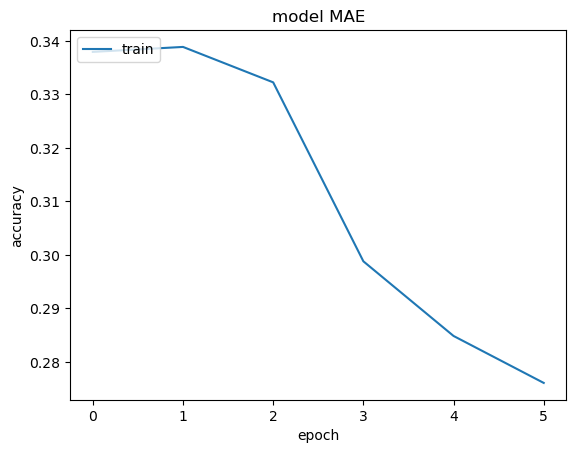

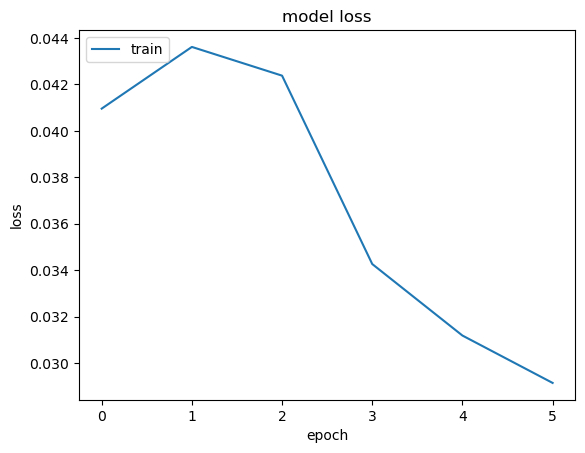

In [17]:
from cnn.utils.visualization import history_show, confusion_show
history_show(history)

最后是加载模型的测试代码

详见[test](test.py)

In [ ]:
from cnn.models import load_model
from scipy.io import loadmat

data = loadmat('data/POI.mat')
data = data['SquPOI'].T
data_mean = data.mean(axis = 0)
data -= data_mean

X_train = data[:600]
y_train = data[1:601]
X_test = data[600:-1]
y_test = data[601:]

model = load_model("model\\standard_POI_rnn.h5")


print(f"模型在测试集上的表现\n{model.evaluate(X_test, y_test)}")


在 idle 上运行上述代码的结果如下

![png](./img/result.png)

接下来我们将模型 standard_POI_rnn 加载进来，测试其单步预测性能和多步预测性能。

In [18]:
import matplotlib.pyplot as plt
from cnn.models import load_model

查看单步预测的效果

可以看到，单步预测的效果极佳，几乎与实际值完全贴合。

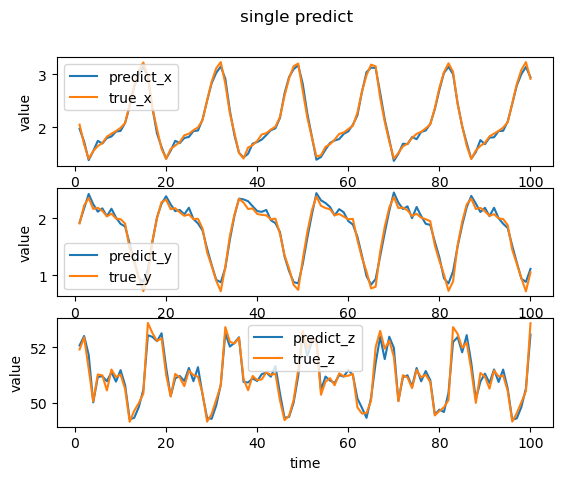

In [25]:
model = load_model("model\\standard_POI_rnn.h5")

y_single = model.predict(X_test)

fig = plt.figure()
fig.suptitle('single predict')

t = np.linspace(1, 100, 100)                # 创建t的取值范围

ax1 = fig.add_subplot(3, 1, 1) 
ax1.plot(t, y_single[:100, 0] + data_mean[0], label='predict_x')
ax1.plot(t, y_test[:100, 0] + data_mean[0], label='true_x')
ax1.set_xlabel('time')
ax1.set_ylabel('value')
ax1.legend()

ax2 = fig.add_subplot(3, 1, 2)  
ax2.plot(t, y_single[:100, 1] + data_mean[1], label='predict_y')
ax2.plot(t, y_test[:100, 1] + data_mean[1], label='true_y')
ax2.set_xlabel('time')
ax2.set_ylabel('value')
ax2.legend()

ax3 = fig.add_subplot(3, 1, 3)    
ax3.plot(t, y_single[:100, 2] + data_mean[2], label='predict_z')
ax3.plot(t, y_test[:100, 2] + data_mean[2], label='true_z')
ax3.set_xlabel('time')
ax3.set_ylabel('value')
ax3.legend()

查看连续预测 100 步的结果

可以看到，连续预测 100 步时，除了刚开始的 10 步可以吻合得较好外，后面已经不再吻合。

预测的整体形状与真实形状具有一定的相似性。

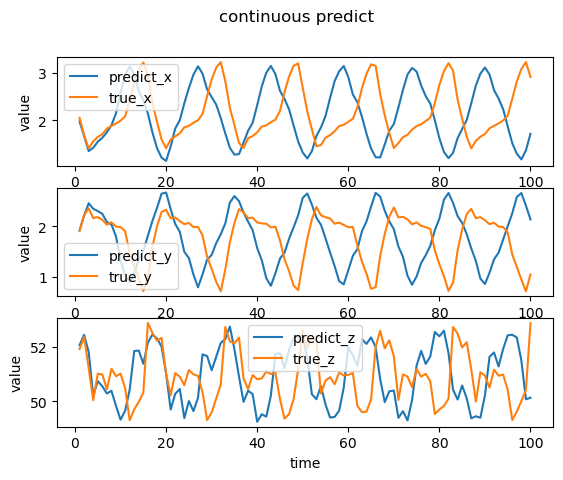

In [27]:
model = load_model("model\\standard_POI_rnn.h5")

input_data = X_test[0].reshape(1, -1)
y_continuous = np.zeros((100, 3))
for i in range(100):
    input_data = model.predict(input_data)
    y_continuous[i] = input_data

fig = plt.figure()
fig.suptitle('continuous predict')

t = np.linspace(1, 100, 100)                # 创建t的取值范围

ax1 = fig.add_subplot(3, 1, 1) 
ax1.plot(t, y_continuous[:100, 0] + data_mean[0], label='predict_x')
ax1.plot(t, y_test[:100, 0] + data_mean[0], label='true_x')
ax1.set_xlabel('time')
ax1.set_ylabel('value')
ax1.legend()

ax2 = fig.add_subplot(3, 1, 2)  
ax2.plot(t, y_continuous[:100, 1] + data_mean[1], label='predict_y')
ax2.plot(t, y_test[:100, 1] + data_mean[1], label='true_y')
ax2.set_xlabel('time')
ax2.set_ylabel('value')
ax2.legend()

ax3 = fig.add_subplot(3, 1, 3)    
ax3.plot(t, y_continuous[:100, 2] + data_mean[2], label='predict_z')
ax3.plot(t, y_test[:100, 2] + data_mean[2], label='true_z')
ax3.set_xlabel('time')
ax3.set_ylabel('value')
ax3.legend()